In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
df_density = pd.read_csv('density.csv')

In [23]:
coople = ['coople/data/coople_11072023.csv','coople/data/coople_11152023.csv','coople/data/coople_11222023.csv','coople/data/coople_11282023.csv']
misgrosi = ['misgrosi/data/misgrosi_job1108.csv','misgrosi/data/misgrosi_job1115.csv','misgrosi/data/misgrosi_job1122.csv','misgrosi/data/misgrosi_job1129.csv']
misgrosi_worker = ['misgrosi/data/misgrosi1108.csv','misgrosi/data/misgrosi1115.csv','misgrosi/data/misgrosi1122.csv','misgrosi/data/misgrosi1129.csv']
zipfel = ['zipfel/data/zipfel_zapf1108.csv','zipfel/data/zipfel_zapf1115.csv','zipfel/data/zipfel_zapf1122.csv','zipfel/data/zipfel_zapf1129.csv']

In [24]:
# Turn a list of csv str to a list of dataframe
def csv_to_df(csv):
    l = []
    for c in csv:
        df = pd.read_csv(c)
        l.append(df)
    return l

# Compare two dataframe and return the record that is in df2 but not df1, that is new record
def new(df1, df2):
    df_new = df2[~df2.isin(df1)].dropna()
    return df_new

# Compare two dataframe and return the record that is in df1 but not df2, that is deleted record
def delete(df1, df2):
    df_deleted = df1[~df1.isin(df2)].dropna()
    return df_deleted

In [25]:
def add_to_overview(platform, tp, d):
    df_list = csv_to_df(platform)
    d['Platform'].append(tp)
    for i in range(4):
        week = 'Week '+str(i+1)
        if week in d:
            d[week].append(df_list[i].shape[0])
        else:
            d[week] = [df_list[i].shape[0]]
    return d
d = add_to_overview(coople,'Coople Gig',{'Platform':[]})
d = add_to_overview(misgrosi,'Misgrosi Gig',d)
d = add_to_overview(misgrosi_worker,'Misgrosi Worker',d)
d = add_to_overview(zipfel,'Zipfel Zapfl Gig',d)
df = pd.DataFrame(d)
df['avg']=(df['Week 1']+df['Week 2']+df['Week 3']+df['Week 4'])//4
# df = df.set_index('Platform')
display(df)

,Platform,Week 1,Week 2,Week 3,Week 4,avg
0,Coople Gig,889,760,892,920,865
1,Misgrosi Gig,1169,1171,1169,1178,1171
2,Misgrosi Worker,103,97,103,103,101
3,Zipfel Zapfl Gig,46,49,51,52,49


In [26]:
def groupby_post_add_urban(df):
    # Urban data group by post code
    df_count = df.groupby(['Post Code']).size().reset_index(name = 'Counts')
    
    # Merge grouped aby data with density.csv
    df = df_count.merge(df_density,on = 'Post Code',how = 'left')
    df['gig_per_capita'] = df['Counts']/df['Population']
    df = df.dropna(subset = ['Density','Population'])
    
    # Define urban column
    df['region'] = 'unknown'
    df.loc[df['Density']<400, 'region'] = 'rural'
    df.loc[(df['Density']>=400) & (df['Density']<1500), 'region'] = 'suburb'
    df.loc[df['Density']>1500, 'region'] = 'urban'
    df = df[df['gig_per_capita']<0.05]
    df = df.rename(columns={'Counts': 'gig_num'})
    return df,df_count

def center_urban_rural(df):
    urban = df[df["region"]=='urban']['gig_per_capita']
    suburb = df[df["region"]=='suburb']['gig_per_capita']
    rural = df[df["region"]=='rural']['gig_per_capita']
    return [urban, suburb, rural]

In [38]:
def new_delete(data):
    # List of new data and deleted data for one platform
    new_data_list, delete_data_list = [],[]
    for i in range(3):
        df_new = new(data[i],data[i+1])
        df_delete = delete(data[i],data[i+1])
        new_data_list.append(df_new)
        delete_data_list.append(df_delete)
    
    # List of data after grouping by post code and categorizing rural and urban
    new_data_urban = [groupby_post_add_urban(df)[0] for df in new_data_list]
    delete_data_urban = [groupby_post_add_urban(df)[0] for df in delete_data_list]
    new_three = [center_urban_rural(df) for df in new_data_urban]
    delete_three = [center_urban_rural(df) for df in delete_data_urban]
    return new_data_urban, delete_data_urban, new_three, delete_three

def plot_hist(new_three,delete_three):
    # Plot three histgrams
    fig, ax = plt.subplots(2, 3, figsize=(25,14))
    c = list(mcolors.BASE_COLORS.keys())
    for i in range(3):
        ax[0,i].hist(new_three[i], bins=20, label =['urban','suburb','rural'],color = c[:3])
        
        ax[0,i].legend()
        ax[0,i].set_xlabel(f'new gig per capita')
        ax[0,i].set_title('NEW '+' vs. '.join(['urban','suburb','rural'])+' histogram'+' WEEK '+str(i+1))
    for i in range(3):
        ax[1,i].hist(delete_three[i], bins=20, label =['urban','suburb','rural'],color = c[:3])
        ax[1,i].legend()
        ax[1,i].set_xlabel('deleted gig per capita')
        ax[1,i].set_title('DELETED '+' vs. '.join(['urban','suburb','rural'])+' histogram'+' WEEK '+str(i+1))
    fig.suptitle('Percentage of New and Deleted Histogram')
    plt.show()

from scipy import stats    
def density_per_scatter(data_list,col1,col2, type):
    fig, ax = plt.subplots(1, 3, figsize=(25,6))
    for i in range(3):
        df = data_list[i]
        ax[i].scatter(x=df[col1],y=df[col2])
        ax[i].set_xlabel('log(density)')
        ax[i].set_ylabel('log(gig_per_capita)')
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
        pr = stats.pearsonr(np.log(df[col1].astype('float')), np.log(df[col2].astype('float')))
        ax[i].set_title(f'WEEK {i+1}')
        
    fig.suptitle(f'{type} and Density Scatter Plot')
    plt.show()

# Dataframe after adding post code with 0 gig percentage
def add_zero_gig(df_count):
    df_count = df_density.merge(df_count,on = 'Post Code', how = 'left')
    df_count['Counts'] = df_count['Counts'].fillna(0)
    df_count = df_count.drop(['City','Region'],axis=1)
    df_count = df_count.dropna(subset = ['Density','Population'])
    df_count['gig_per_capita'] = df_count['Counts']/df_count['Population']
    df_count = df_count.rename(columns={'Counts': 'gig_num'})
    return df_count

In [39]:
def platform_hist_corr(csv):
    data = csv_to_df(csv)
    new_data_list, delete_data_list, new_three, delete_three = new_delete(data)
    plot_hist(new_three, delete_three)
    try:
        density_per_scatter(new_data_list,'Density','gig_per_capita', 'NEW Gig per Capita')
        density_per_scatter(delete_data_list,'Density','gig_per_capita', 'DELETED Gig per Capita')

        new_temp = [groupby_post_add_urban(df)[1] for df in new_data_list]
        new_count_list = [add_zero_gig(df) for df in new_temp]
        delete_temp = [groupby_post_add_urban(df)[1] for df in delete_data_list]
        delete_count_list = [add_zero_gig(df) for df in delete_temp]
        density_per_scatter(new_count_list,'Density','gig_per_capita', 'NEW Gig per Capita')
        density_per_scatter(delete_count_list,'Density','gig_per_capita', 'DELETED Gig per Capita')
    except:
        print('No correlation plot available')


In [40]:
def summary(platform, name):
    index = ['Week 1','Week 2','Week 3']
    data = [pd.read_csv(c) for c in platform]
    new_data_list, delete_data_list =[],[]
    for i in range(3):
        new_data_list.append(new(data[i],data[i+1]))
        delete_data_list.append(delete(data[i],data[i+1]))
    new_num = [df.shape[0] for df in new_data_list]
    delete_num = [df.shape[0] for df in delete_data_list]
    
    df = pd.DataFrame({'New': new_num,'Deleted': delete_num}, index=index)
    axes = df.plot.bar(rot=0, color={"New": "blue", "Deleted": "orange"})
    plt.title(f'Number of New and Deleted Jobs for {name}')
    plt.savefig(f'{name}_overview.png')

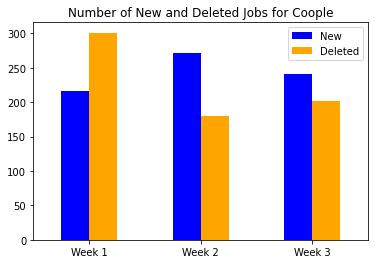

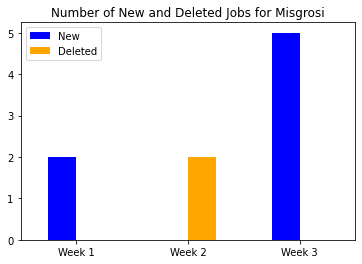

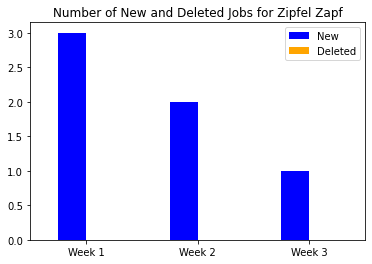

In [41]:
summary(coople,'Coople')
summary(misgrosi,'Misgrosi') 
summary(zipfel,'Zipfel Zapf')

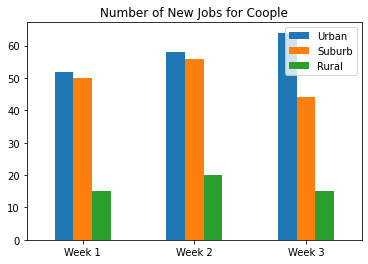

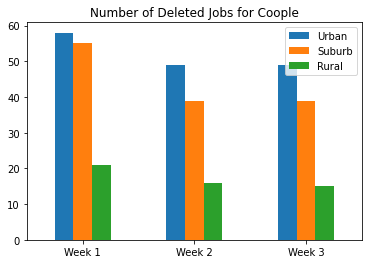

In [42]:
def summary_urban(platform, name):
    new_data_urban, delete_data_urban, new_three, delete_three = new_delete(csv_to_df(platform))
    index = ['Week 1','Week 2','Week 3']
    new_data_list, delete_data_list =[],[]
    for i in range(3):
        new_data_list.append(new_data_urban[i]['region'].value_counts())
        delete_data_list.append(delete_data_urban[i]['region'].value_counts())
    new_urban_center = [df.values[0] for df in new_data_list]
    new_urban = [df.values[1] for df in new_data_list]  
    new_rural = [df.values[2] for df in new_data_list] 
    delete_urban_center = [df.values[0] for df in delete_data_list]
    delete_urban = [df.values[1] for df in delete_data_list]  
    delete_rural = [df.values[2] for df in delete_data_list] 
    
    df1 = pd.DataFrame({'Urban': new_urban_center,'Suburb': new_urban,'Rural':new_rural}, index=index)
    df1.plot.bar(rot=0)
    plt.title(f'Number of New Jobs for {name}')
    plt.savefig('coople_region_new.png')
    df2 = pd.DataFrame({'Urban': delete_urban_center,'Suburb': delete_urban,'Rural':delete_rural}, index=index)
    df2.plot.bar(rot=0)
    plt.title(f'Number of Deleted Jobs for {name}')
    plt.savefig('coople_region_deleted.png')
summary_urban(coople,'Coople')

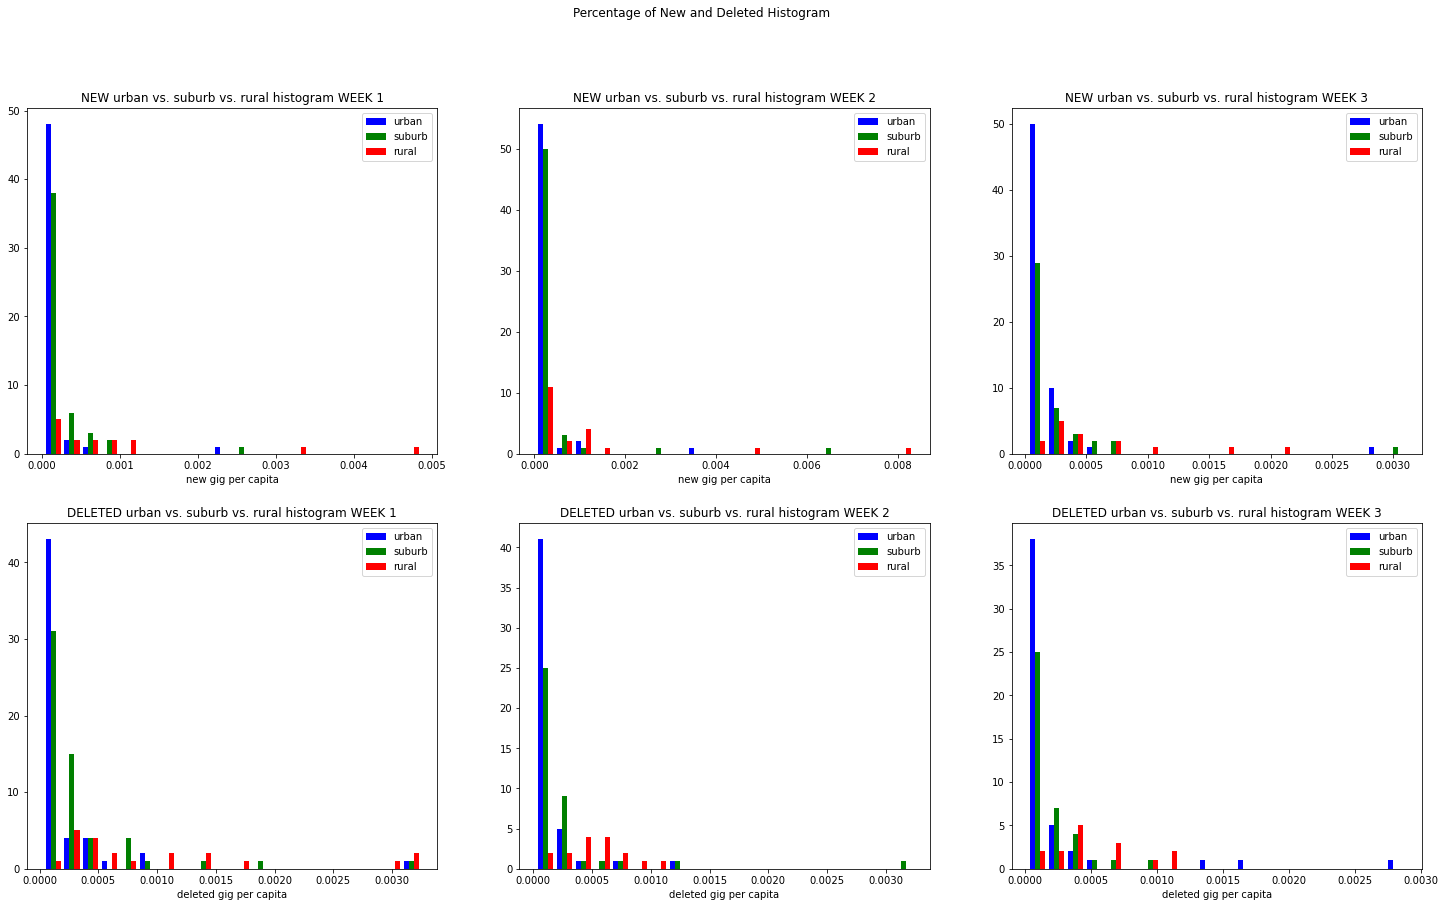

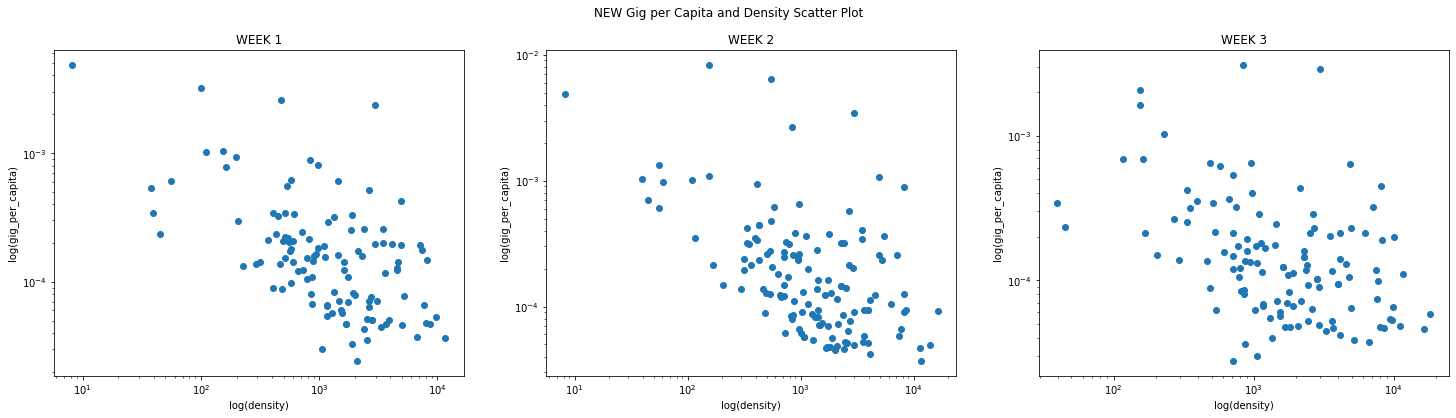

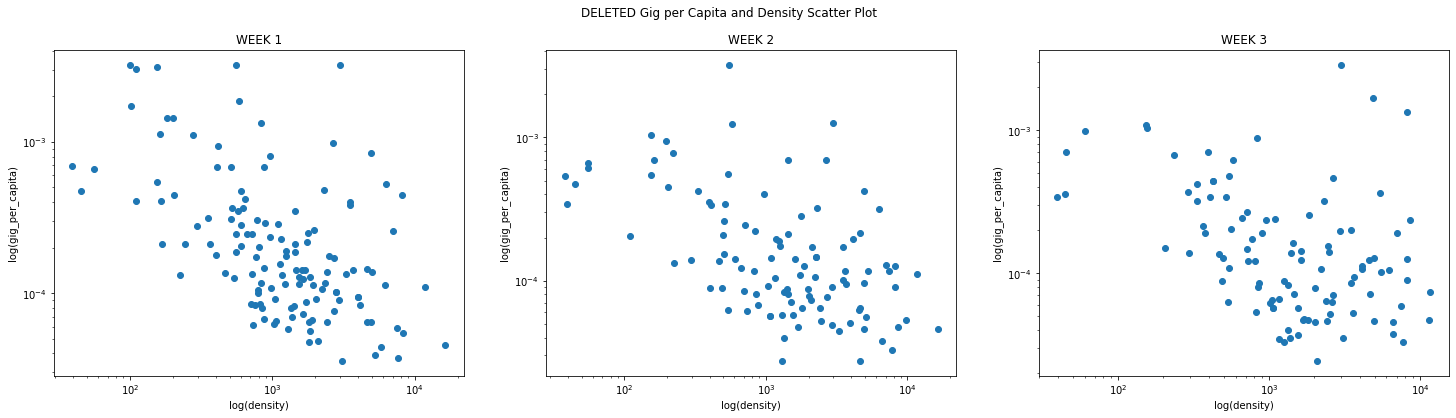

No correlation plot available


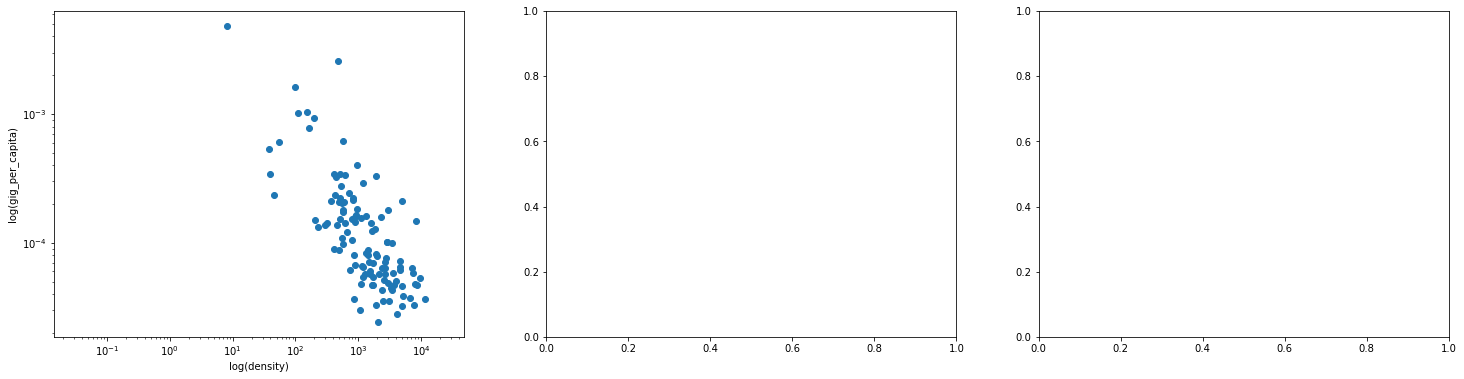

In [43]:
platform_hist_corr(coople)

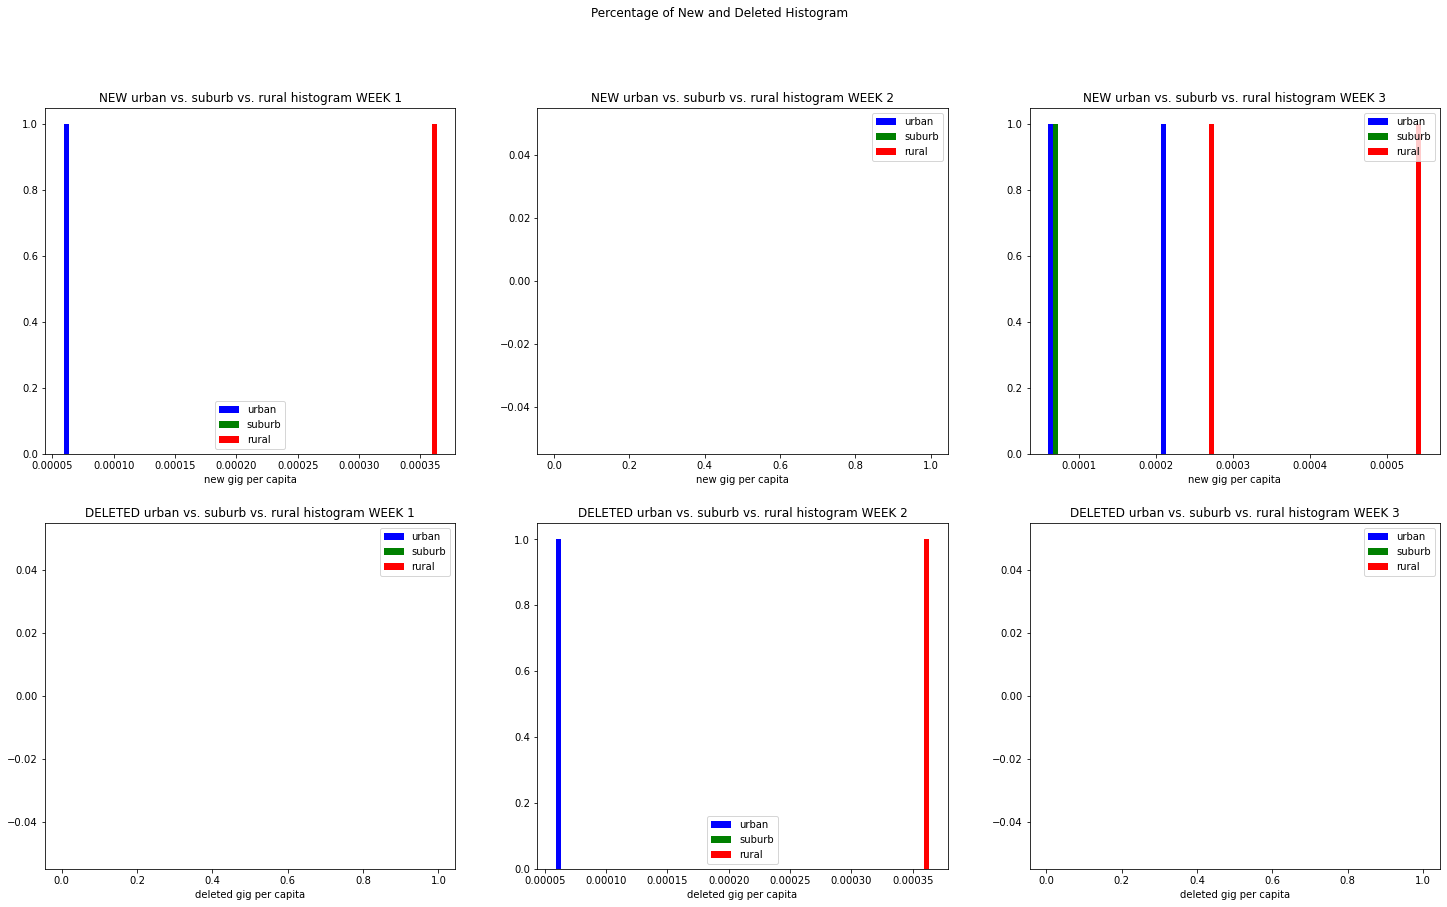

No correlation plot available


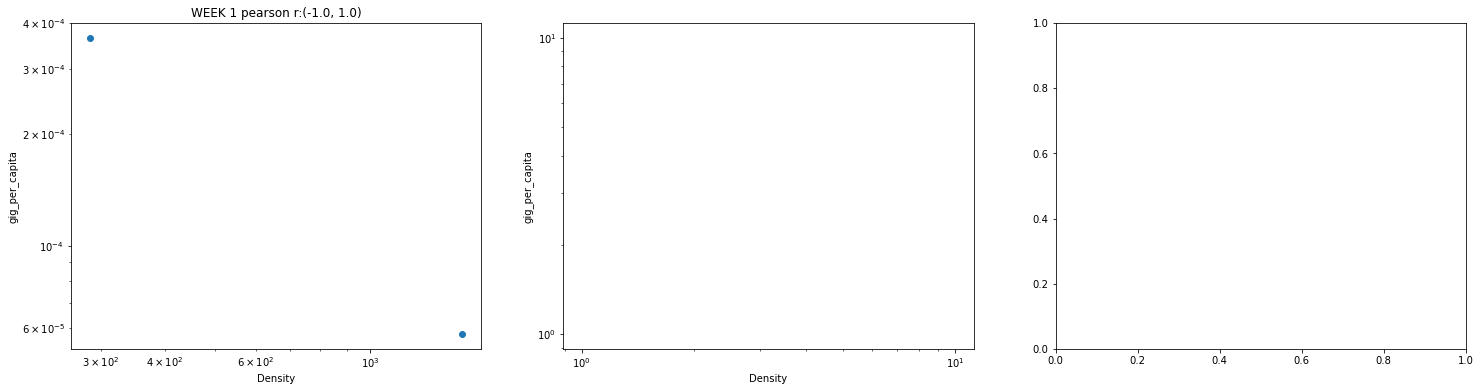

In [13]:
platform_hist_corr(misgrosi)

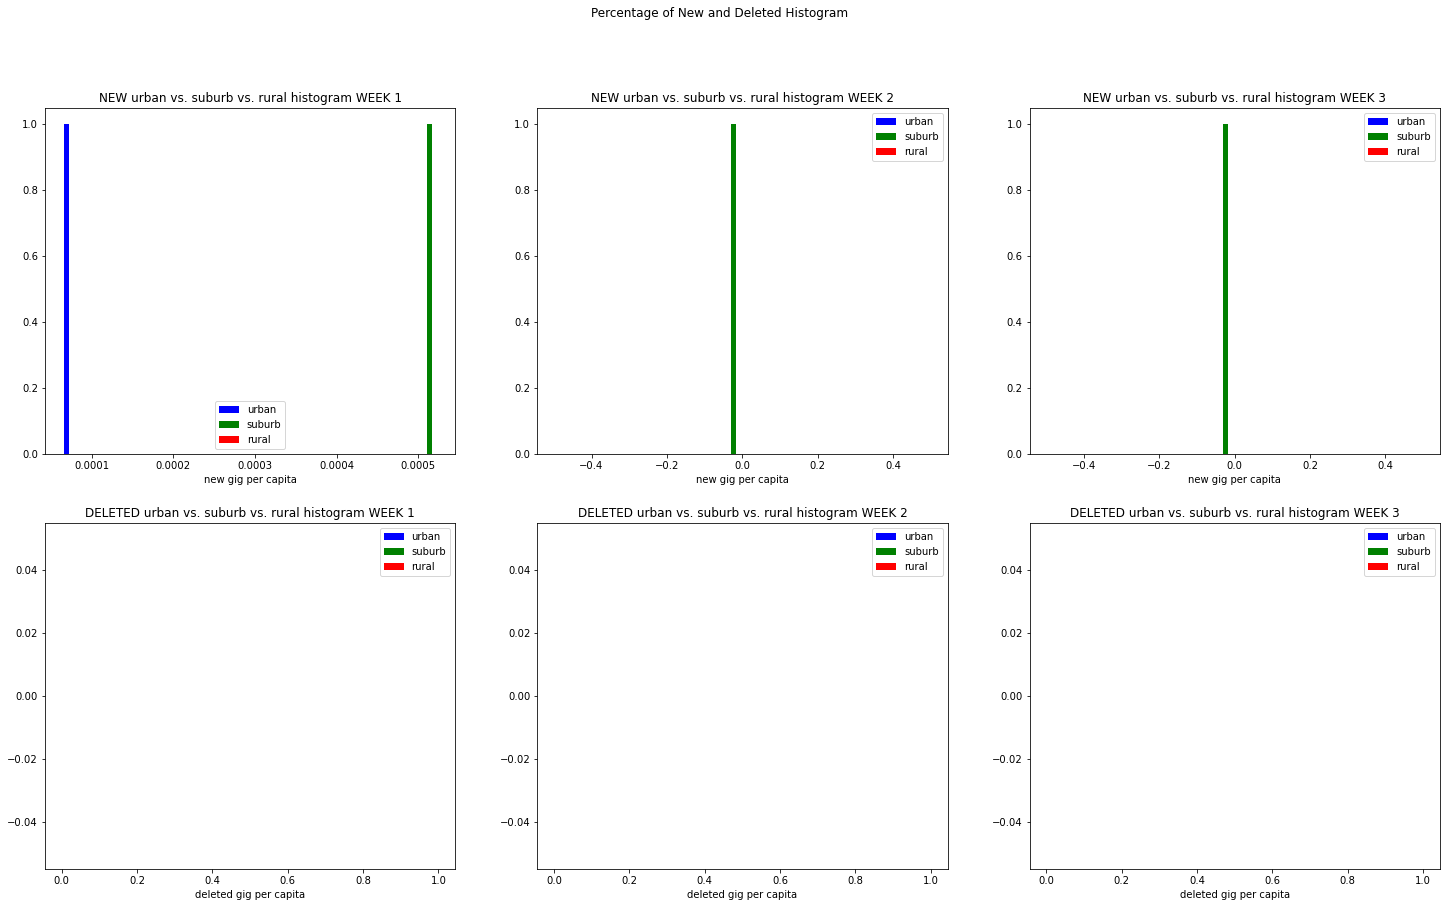

No correlation plot available


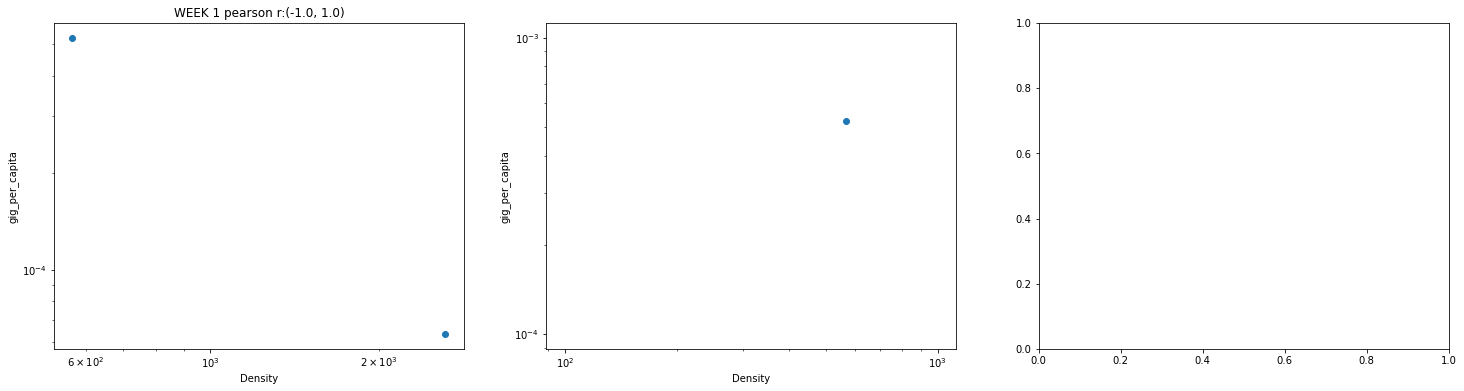

In [14]:
platform_hist_corr(zipfel)